In [1]:
import gensim
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, BatchNormalization, Activation, Bidirectional
from keras.preprocessing.text import text_to_word_sequence, Tokenizer
from keras.preprocessing.sequence import pad_sequences

import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt
from keras.utils import plot_model 
from IPython.display import Image

Using TensorFlow backend.


In [2]:
# Specify the folder locations
W2V_DIR = '/Users/hareeshbahuleyan/Downloads/GoogleNews-vectors-negative300.bin'
DATA_DIR = '/Users/hareeshbahuleyan/Github/deeplearning-tutorials/text-classification-lstm/data/'

# These are some hyperparameters that can be tuned
MAX_SENT_LEN = 30
MAX_VOCAB_SIZE = 20000
LSTM_DIM = 128
EMBEDDING_DIM = 300
BATCH_SIZE = 32
N_EPOCHS = 10

In [3]:
# Read the text files of positive and negative sentences
with open(DATA_DIR+'rt-polarity.neg', 'r', errors='ignore') as f:
    neg = f.readlines()
    
with open(DATA_DIR+'rt-polarity.pos', 'r', errors='ignore') as f:
    pos = f.readlines()

print('Number of negative sentences:', len(neg))
print('Number of positive sentences:', len(pos))

# Create a dataframe to store the sentence and polarity as 2 columns
df = pd.DataFrame(columns=['sentence', 'polarity'])
df['sentence'] = neg + pos
df['polarity'] = [0]*len(neg) + [1]*len(pos)
df = df.sample(frac=1, random_state=10) # Shuffle the rows
df.reset_index(inplace=True, drop=True)

Number of negative sentences: 5331
Number of positive sentences: 5331


In [4]:
# Pre-processing involves removal of puctuations and converting text to lower case
word_seq = [text_to_word_sequence(sent) for sent in df['sentence']]
print('90th Percentile Sentence Length:', np.percentile([len(seq) for seq in word_seq], 90))

90th Percentile Sentence Length: 31.0


<code>Since only 10 percent of the sentences have more than 31 words, we should be safe using MAX_SENT_LEN as 30

In [5]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])

print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 19180


<code>The number of unique words are less than our MAX_VOCAB_SIZE limit

In [6]:
# Convert the sequence of words to sequnce of indices
X = tokenizer.texts_to_sequences([' '.join(seq[:MAX_SENT_LEN]) for seq in word_seq])
X = pad_sequences(X, maxlen=MAX_SENT_LEN, padding='post', truncating='post')

y = df['polarity']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, test_size=0.1)

In [8]:
# Load the word2vec embeddings 
embeddings = gensim.models.KeyedVectors.load_word2vec_format(W2V_DIR, binary=True)

# Create an embedding matrix containing only the word's in our vocabulary
# If the word does not have a pre-trained embedding, then randomly initialize the embedding
embeddings_matrix = np.random.uniform(-0.05, 0.05, size=(len(tokenizer.word_index)+1, EMBEDDING_DIM)) # +1 is because the matrix indices start with 0
for word, i in tokenizer.word_index.items(): # i=0 is the embedding for the zero padding
    try:
        embeddings_vector = embeddings[word]
    except KeyError:
        embeddings_vector = None
    if embeddings_vector is not None:
        embeddings_matrix[i] = embeddings_vector
        
del embeddings

In [9]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True))

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         5754300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
output_layer (Dense)         (None, 1)                 129       
Total params: 5,974,077
Trainable params: 219,777
Non-trainable params: 5,754,300
_________________________________________________________________


In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [13]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 27s - loss: 0.5470 - acc: 0.7269 - val_loss: 0.4838 - val_acc: 0.7629
Epoch 2/10
9595/9595 [==============================] - 26s - loss: 0.4678 - acc: 0.7831 - val_loss: 0.4597 - val_acc: 0.7723
Epoch 3/10
9595/9595 [==============================] - 27s - loss: 0.4400 - acc: 0.7943 - val_loss: 0.4683 - val_acc: 0.7704
Epoch 4/10
9595/9595 [==============================] - 26s - loss: 0.4169 - acc: 0.8061 - val_loss: 0.4505 - val_acc: 0.7985
Epoch 5/10
9595/9595 [==============================] - 27s - loss: 0.3948 - acc: 0.8199 - val_loss: 0.4366 - val_acc: 0.7844
Epoch 6/10
9595/9595 [==============================] - 27s - loss: 0.3728 - acc: 0.8330 - val_loss: 0.4184 - val_acc: 0.8032
Epoch 7/10
9595/9595 [==============================] - 27s - loss: 0.3535 - acc: 0.8413 - val_loss: 0.4367 - val_acc: 0.7910
Epoch 8/10
9595/9595 [==============================] - 26s - loss: 0.

In [14]:
score, acc = model.evaluate(X_test, y_test,
                            batch_size=BATCH_SIZE)

1056/1067 [============================>.] - ETA: 0s

In [15]:
print("Accuracy on Test Set = {0:4.3f}".format(acc))

Accuracy on Test Set = 0.802


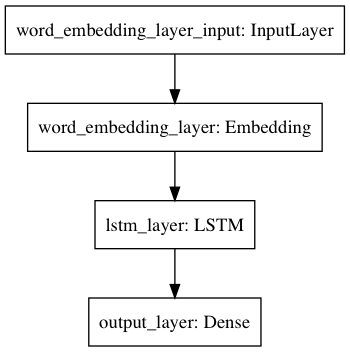

In [16]:
plot_model(model, to_file='basic_lstm_classifier.png', show_layer_names=True)
Image('basic_lstm_classifier.png')

<code>Modify the network by adding two more Dense layers with Batch-Normalization and Dropouts:

In [11]:
# Build a sequential model by stacking neural net units 
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1,
                          output_dim=EMBEDDING_DIM,
                          weights = [embeddings_matrix], trainable=False, name='word_embedding_layer', 
                          mask_zero=True)) # trainable=True results in overfitting

model.add(LSTM(LSTM_DIM, return_sequences=False, name='lstm_layer')) # Can try Bidirectional-LSTM

model.add(Dense(32, name='dense_1'))
# model.add(BatchNormalization(name='bn_1')) # BN did not really help with performance 
model.add(Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(Activation(activation='relu', name='activation_1'))

model.add(Dense(8, name='dense_2'))
# model.add(BatchNormalization(name='bn_2'))
model.add(Dropout(rate=0.3, name='dropout_2'))
model.add(Activation(activation='relu', name='activation_2'))

model.add(Dense(1, activation='sigmoid', name='output_layer'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_embedding_layer (Embedd (None, None, 300)         5754300   
_________________________________________________________________
lstm_layer (LSTM)            (None, 128)               219648    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 264       
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
__________

In [12]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [33]:
model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=N_EPOCHS,
          validation_data=(X_test, y_test))

Train on 9595 samples, validate on 1067 samples
Epoch 1/10
9595/9595 [==============================] - 41s - loss: 0.5703 - acc: 0.7141 - val_loss: 0.4678 - val_acc: 0.7694
Epoch 2/10
9595/9595 [==============================] - 40s - loss: 0.4994 - acc: 0.7718 - val_loss: 0.4759 - val_acc: 0.7629
Epoch 3/10
9595/9595 [==============================] - 40s - loss: 0.4610 - acc: 0.7925 - val_loss: 0.4483 - val_acc: 0.7798
Epoch 4/10
9595/9595 [==============================] - 41s - loss: 0.4404 - acc: 0.8021 - val_loss: 0.4306 - val_acc: 0.8022
Epoch 5/10
9595/9595 [==============================] - 41s - loss: 0.4080 - acc: 0.8201 - val_loss: 0.4402 - val_acc: 0.7919
Epoch 6/10
9595/9595 [==============================] - 40s - loss: 0.3818 - acc: 0.8323 - val_loss: 0.4372 - val_acc: 0.8154
Epoch 7/10
9595/9595 [==============================] - 40s - loss: 0.3525 - acc: 0.8459 - val_loss: 0.4291 - val_acc: 0.8088
Epoch 8/10
9595/9595 [==============================] - 40s - loss: 0.

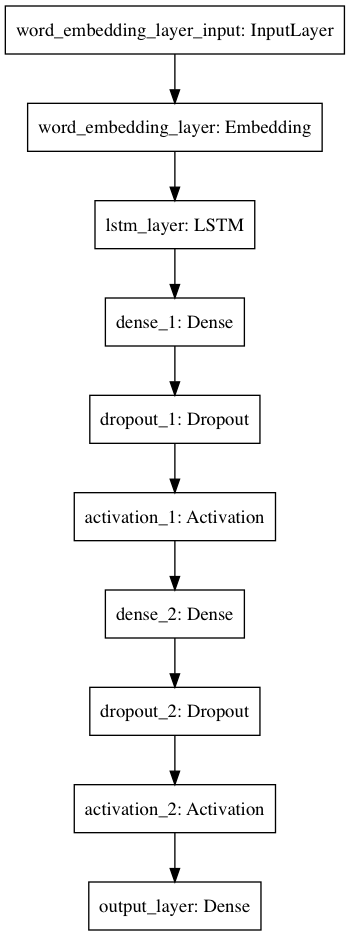

In [13]:
plot_model(model, to_file='modified_lstm_classifier.png', show_layer_names=True)
Image('modified_lstm_classifier.png')